In [1]:
import datetime

import numpy as np

import pandas as pd
from pandas import Grouper
from pandas.plotting import autocorrelation_plot, lag_plot

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from scipy import optimize
from scipy.interpolate import UnivariateSpline

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from bokeh.io       import show, output_notebook
from bokeh.layouts  import layout
from bokeh.models   import Range1d
from bokeh.palettes import d3
from bokeh.plotting import figure

output_notebook()

tools = "pan,wheel_zoom,box_zoom,reset,save".split(',')

pd.set_option('display.max_columns', 40)

mycolors = [d3['Category10'][10][i] for i in range(10)]

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,sklearn,matplotlib,bokeh
print("")
%watermark -m

/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading BokehJS ...

Author: gmalim

last updated: Sun Aug 05 2018

CPython 3.6.5
IPython 6.5.0

numpy 1.15.0
pandas 0.23.4
sklearn 0.19.2
matplotlib 2.2.2
bokeh 0.13.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


In [2]:
df = pd.read_csv('KNMI_DeBilt_alldata.csv', comment='#', skipinitialspace=True, 
                 index_col='DATE', parse_dates=['DATE']) #, usecols=['DATE','TG','TN','TX'], \
                 #dtype={'TG':np.float64, 'TN':np.float64, 'TX':np.float64})

print(df.shape)

(42949, 40)


In [3]:
display(df.head())

,STN,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,EV24,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1901-01-01,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49,-65,NaN,-24,NaN,NaN,NaN,28.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN
1901-01-02,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18,-33,NaN,-14,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN
1901-01-03,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-26,-76,NaN,-6,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,NaN,NaN,NaN,NaN
1901-01-04,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65,-90,NaN,-11,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,NaN
1901-01-05,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-60,-82,NaN,-20,NaN,NaN,NaN,36.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN


In [4]:
df.drop(['STN', 'FHXH', 'FHNH', 'FXXH', 'TNH', 'TXH', 'T10N', 'T10NH', 
         'RHXH', 'PXH', 'PNH', 'VVNH', 'VVXH', 'UXH', 'UNH'], axis=1, inplace=True)

# Convert temperatures to degrees Celsius:
df[['TG', 'TN', 'TX']] = df[['TG', 'TN', 'TX']].multiply(0.1, axis=0)
# Convert precipitation amounts and evapotranspiration to mm:
df[['RH', 'RHX', 'EV24']] = df[['RH', 'RHX', 'EV24']].multiply(0.1, axis=0)
# Convert sunshine duration to hours:
df[['SQ']] = df[['SQ']].multiply(0.1, axis=0) 
# Normalize cloud cover:
df[['NG']] = df[['NG']].multiply(12.5, axis=0)
# Convert visibilities to m:
df[['VVN', 'VVX']] = df[['VVN', 'VVX']].mask(df[['VVN', 'VVX']] <= 50, 
                                             df[['VVN', 'VVX']]*100)
df[['VVN', 'VVX']] = df[['VVN', 'VVX']].mask((df[['VVN', 'VVX']] > 50) & (df[['VVN', 'VVX']] <= 56), 
                                             df[['VVN', 'VVX']]*200)
df[['VVN', 'VVX']] = df[['VVN', 'VVX']].mask((df[['VVN', 'VVX']] > 56) & (df[['VVN', 'VVX']] <= 80), 
                                             (df[['VVN', 'VVX']] - 50)*1000)
df[['VVN', 'VVX']] = df[['VVN', 'VVX']].mask((df[['VVN', 'VVX']] > 80) & (df[['VVN', 'VVX']] <= 89), 
                                             (df[['VVN', 'VVX']] - 80)*5000 + 30000)
# Convert pressures to hPa:
df[['PG', 'PN', 'PX']] = df[['PG', 'PN', 'PX']].multiply(0.1, axis=0)
# Convert windspeeds to m/s:
df[['FHVEC', 'FHN', 'FG', 'FHX', 'FXX']] = df[['FHVEC', 'FHN', 'FG', 'FHX', 'FXX']].multiply(0.1, axis=0) 

df[['SQ','RH','RHX']] = df[['SQ','RH','RHX']].replace(-0.1, 0) # Replace negative values with zero

print(df.columns)

Index(['DDVEC', 'FHVEC', 'FG', 'FHX', 'FHN', 'FXX', 'TG', 'TN', 'TX', 'SQ',
       'SP', 'Q', 'DR', 'RH', 'RHX', 'EV24', 'PG', 'PX', 'PN', 'VVN', 'VVX',
       'NG', 'UG', 'UX', 'UN'],
      dtype='object')


In [5]:
# Date selection:

start_year = 2010
end_year   = 2018

start_date = '{}-01-01'.format(start_year)
end_date   = '{}-12-31'.format(end_year)

df = df.loc[start_date:end_date]

df_zero = pd.DataFrame(0, index=np.arange(df.shape[0]), columns=[['zero']])

#print(df.index)

In [6]:
display(df.describe().round(1))

,DDVEC,FHVEC,FG,FHX,FHN,FXX,TG,TN,TX,SQ,SP,Q,DR,RH,RHX,EV24,PG,PX,PN,VVN,VVX,NG,UG,UX,UN
count,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0,3137.0
mean,191.8,3.0,3.4,5.2,1.7,10.1,10.6,6.3,14.6,4.9,37.6,1038.6,18.2,2.3,0.9,1.7,1015.3,1018.3,1012.3,5957.2,28583.6,70.8,80.1,95.2,62.4
std,92.3,1.5,1.4,1.8,1.2,3.6,6.3,5.8,7.3,4.1,29.8,782.8,30.8,4.9,2.0,1.4,9.3,8.8,10.0,5444.6,10716.4,28.0,9.8,5.4,15.1
min,1.0,0.0,0.5,1.0,0.0,2.0,-12.1,-18.9,-6.1,0.0,0.0,25.0,0.0,0.0,0.0,0.0,976.0,977.2,969.2,0.0,100.0,0.0,31.0,43.0,18.0
25%,127.0,1.9,2.4,4.0,1.0,8.0,6.1,2.2,9.1,1.0,9.0,335.0,0.0,0.0,0.0,0.4,1009.9,1013.1,1006.3,1500.0,22000.0,50.0,74.0,94.0,51.0
50%,209.0,2.8,3.2,5.0,1.0,10.0,10.6,6.6,14.6,4.2,34.0,886.0,2.0,0.1,0.1,1.3,1015.9,1018.6,1013.0,4200.0,29000.0,75.0,81.0,97.0,63.0
75%,252.0,3.8,4.1,6.0,2.0,12.0,15.6,10.8,20.2,7.9,62.0,1614.0,25.0,2.5,1.1,2.6,1021.5,1024.0,1018.8,10000.0,35000.0,100.0,87.0,98.0,74.0
max,360.0,10.6,10.6,14.0,9.0,34.0,29.7,22.4,35.7,15.3,94.0,3062.0,240.0,63.9,33.3,5.9,1044.5,1045.6,1042.7,30000.0,45000.0,100.0,100.0,100.0,99.0


## Temperature:

In [7]:
npoints = df.shape[0]
print("--> Total number of data points in selected date range =", npoints)

print("")

TX_mean = df.TX.mean()
TG_mean = df.TG.mean()
TN_mean = df.TN.mean()

TX_median = df.TX.median()
TG_median = df.TG.median()
TN_median = df.TN.median()

print("--> Mean (median) maximum daily temperature = {:5.2f} ({:5.2f}) degrees Celsius".format(TX_mean, TX_median))
print("--> Mean (median) average daily temperature = {:5.2f} ({:5.2f}) degrees Celsius".format(TG_mean, TG_median))
print("--> Mean (median) minimum daily temperature = {:5.2f} ({:5.2f}) degrees Celsius".format(TN_mean, TN_median))

--> Total number of data points in selected date range = 3137

--> Mean (median) maximum daily temperature = 14.62 (14.60) degrees Celsius
--> Mean (median) average daily temperature = 10.63 (10.60) degrees Celsius
--> Mean (median) minimum daily temperature =  6.33 ( 6.60) degrees Celsius


In [8]:
print("--> Total number of days in data set with maximum temperature > 30 C =", len(df[(df['TX']>30)]))

--> Total number of days in data set with maximum temperature > 30 C = 35


--> Total number of data points in 2010 = 365
--> Total number of data points in 2011 = 365
--> Total number of data points in 2012 = 366
--> Total number of data points in 2013 = 365
--> Total number of data points in 2014 = 365
--> Total number of data points in 2015 = 365
--> Total number of data points in 2016 = 366
--> Total number of data points in 2017 = 365
--> Total number of data points in 2018 = 215


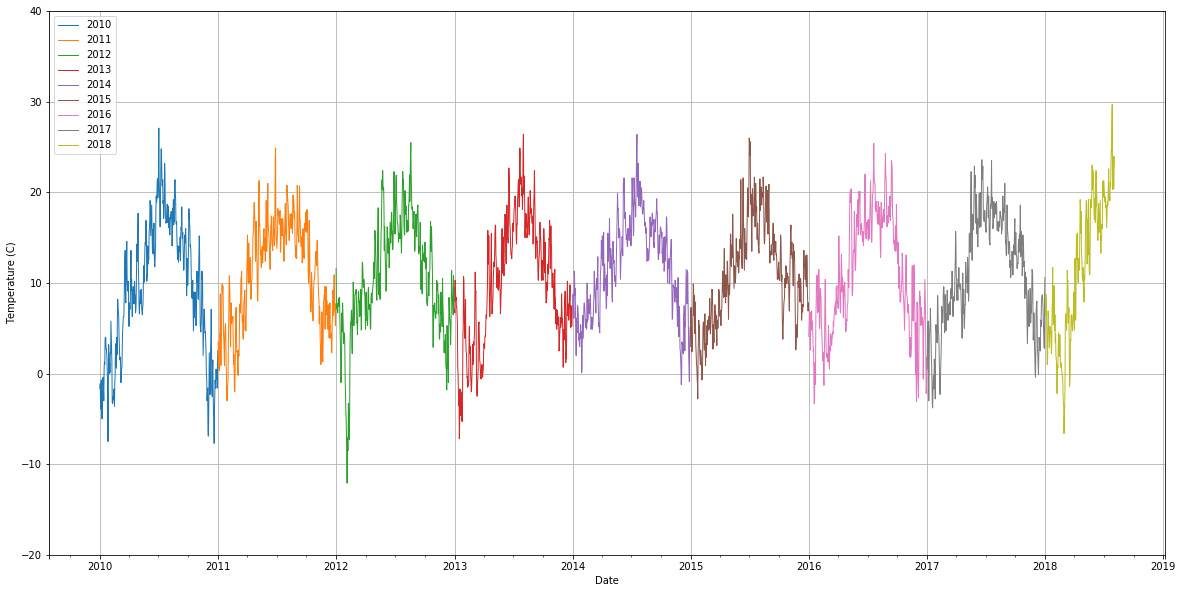

In [9]:
plt.figure(figsize=(20,10))

groups = df['TG'].groupby(Grouper(freq='A'))

for name, group in groups:
    print("--> Total number of data points in {} = {}".format(name.year, len(group.values)))
    #print(group.values)
    group.plot(label=name.year, lw=1)

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
#plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
plt.ylim(-20, 40)
plt.grid(True)

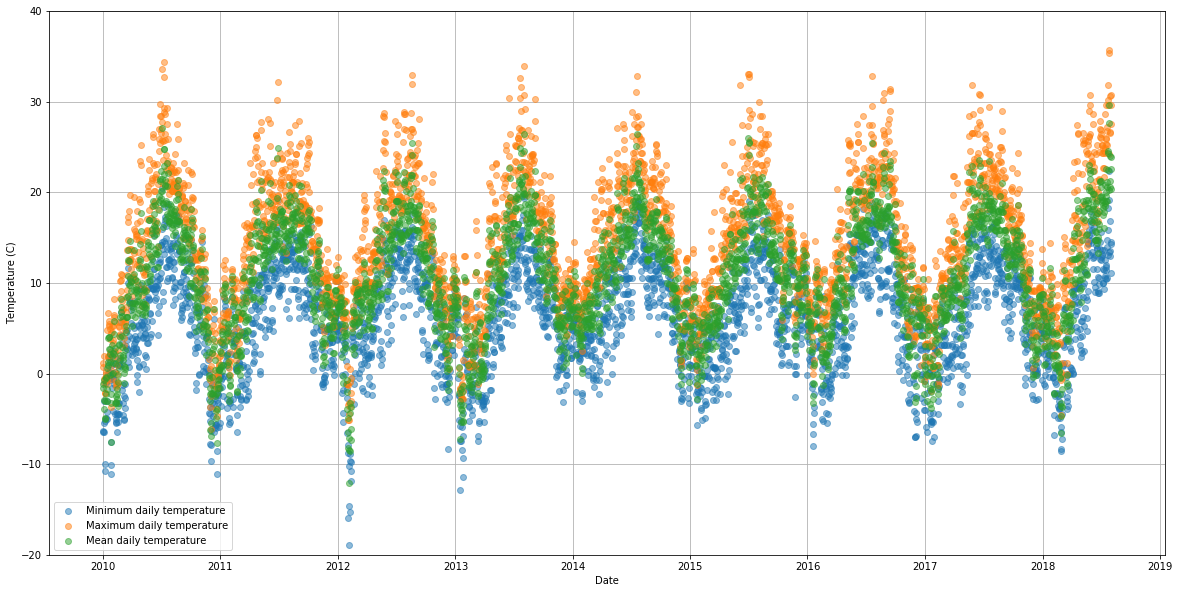

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(x=df.index, y=df.TN, label='Minimum daily temperature', alpha=0.5, zorder=10)
plt.scatter(x=df.index, y=df.TX, label='Maximum daily temperature', alpha=0.5, zorder=10)
plt.scatter(x=df.index, y=df.TG, label='Mean daily temperature',    alpha=0.5, zorder=10)

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
#plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
plt.ylim(-20, 40)
plt.grid(True)

In [11]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI temperature data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Temperature (C)"
fig1.y_range=Range1d(-20,40)

fig1.circle(x=df.index, y=df.TX, legend='Maximum daily temperature',
            size=3, color=mycolors[1], muted_color=mycolors[1], alpha=0.5, muted_alpha=0.03)
fig1.circle(x=df.index, y=df.TG, legend='Average daily temperature',
            size=3, color=mycolors[2], muted_color=mycolors[2], alpha=0.5, muted_alpha=0.03)
fig1.circle(x=df.index, y=df.TN, legend='Minimum daily temperature',
            size=3, color=mycolors[0], muted_color=mycolors[0], alpha=0.5, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

NameError: name 'c1' is not defined

In [ ]:
plt.figure(figsize=(20,10))
plt.fill_between(df.index, df.TN, df.TX, color='red', alpha=0.5, label='Daily temperature range', zorder=10)
plt.plot(df.index, df.TG, color='black', label='Mean daily temperature', zorder=20)

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
#plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
plt.ylim(-20, 40)
plt.grid(True)

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI temperature data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Temperature (C)"
fig1.y_range=Range1d(-20,40)

band_x = np.append(df.index, df.index[::-1])
band_y = np.append(df.TN,    df.TX   [::-1])

fig1.patch(band_x, band_y, legend='Daily temperature range',
           color='gold', muted_color='gold', alpha=0.7, fill_alpha=0.2, muted_alpha=0.03)

fig1.line(x=df.index, y=df.TG, legend='Daily mean temperature',
          line_width=1, color=mycolors[0], muted_color=mycolors[0], alpha=0.7, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(x=df.TN, range=(-20,40), bins=60, alpha=0.5, zorder=10, label='Minimum daily temperature')
plt.hist(x=df.TX, range=(-20,40), bins=60, alpha=0.5, zorder=10, label='Maximum daily temperature')

plt.axvline(x=TN_mean, color='C0', linestyle='--', zorder=20, label='Mean minimum daily temperature')
plt.axvline(x=TX_mean, color='C1', linestyle='--', zorder=20, label='Mean maximum daily temperature')

plt.legend(loc='best')
plt.ylabel('# of data points')
plt.xlabel('Temperature (C)')
plt.grid(True)

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(x=df.TN, range=(-20,40), bins=600, density=True, histtype='step',
         cumulative=True, label='Minimum daily temperature', lw=3)
plt.hist(x=df.TX, range=(-20,40), bins=600, density=True, histtype='step',
         cumulative=True, label='Maximum daily temperature', lw=3)

plt.axvline(x=TN_median, color='C0', linestyle='--', label='Median minimum daily temperature')
plt.axvline(x=TX_median, color='C1', linestyle='--', label='Median maximum daily temperature')
plt.axhline(y=0.5, color='grey', linestyle='--', lw=1)

plt.legend(loc='upper left')
plt.ylabel('Cumulative probability')
plt.xlabel('Temperature (C)')
plt.grid(True)

In [ ]:
plt.figure(figsize=(10,5))
autocorrelation_plot(df[['TG']], lw=3)

nlines = 2*(end_year-start_year+1)

color=iter(cm.tab20(np.linspace(0,1,nlines)))

for i in range(1,nlines):
    x=i*182.5
    c=next(color)
    plt.axvline(x=x, color=c, linestyle='--', lw=1, label='{} year'.format(i/2))

plt.xlabel('Time (days)')
plt.legend(loc='right')
plt.grid(False)

In [ ]:
plt.figure(figsize=(10, 10))

for lag in range(1,5):

    plt.subplot(2, 2, lag)

    plt.title("Lag = {}".format(lag))
    
    lag_plot(df[['TG']], lag=lag, marker='o', c=mycolors[lag-1], alpha=0.2, zorder=10)

    xmin, xmax = plt.xlim()
    plt.plot(np.linspace(xmin,xmax), np.linspace(xmin,xmax), lw=1, ls='--', color='grey')
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)

    plt.grid(True)
    plt.tight_layout()

In [ ]:
def mysinfunction(x, ampl, period, hoffset, voffset):
    return ampl*np.sin(2*np.pi/period*(x - hoffset)) + voffset

start_param = [1, 365, 1, 0]
param_min = (     0,  365,  0, -np.inf) # (-np.inf, -np.inf, -np.inf, -np.inf)
param_max = (np.inf, 366, 366,  np.inf) # ( np.inf,  np.inf,  np.inf,  np.inf)
param_bounds = (param_min, param_max)

In [ ]:
df = df.reset_index()

x_fit = df.index
y_fit = df.TG

params, params_covariance = optimize.curve_fit(mysinfunction, x_fit, y_fit, p0=start_param, bounds=param_bounds)

print("--> Fitted sine function: {:.1f} * sin(2*pi*(t - {:.1f})/{:.1f}) + {:.1f}"\
      .format(params[0], params[2], params[1], params[3]))

In [ ]:
myspline = UnivariateSpline(x_fit, y_fit, s=npoints*10)
x_splinefit = np.linspace(x_fit.min(), x_fit.max(), npoints*10)
y_splinefit = myspline(x_splinefit)

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x=x_fit, y=y_fit, label='Average daily temperature data', color=mycolors[0], zorder=10)
plt.plot(mysinfunction(x_fit, params[0], params[1], params[2], params[3]), 
         label='Fitted sine function', color=mycolors[1], lw=3, zorder=20)
plt.plot(x_splinefit, y_splinefit, label='Fitted spline function', color=mycolors[3], lw=3, zorder=30)
#plt.plot(x_fit, y_RFfit,  label='Fitted random forest regressor', color='purple', lw=3, zorder=10)
#plt.plot(x_fit, y_MLPfit, label='Fitted MLP regressor', color='orange', lw=3, zorder=10)

plt.legend(loc='best')
plt.xlabel('Time (days)')
plt.ylabel('Temperature (C)')
#plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
plt.ylim(-15, 30)
plt.grid(True)

## Sea level pressure:

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI pressure data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Sea level pressure (hPa)"
fig1.y_range=Range1d(960,1060)

band_x = np.append(df.index, df.index[::-1])
band_y = np.append(df.PN,    df.PX   [::-1])

fig1.patch(band_x, band_y, legend='Daily sea level pressure range',
           color='gold', muted_color='gold', alpha=0.7, fill_alpha=0.2, muted_alpha=0.03)

fig1.line(x=df.index, y=df.PG, legend='Daily mean sea level pressure',
          line_width=1, color=mycolors[0], muted_color=mycolors[0], alpha=0.7, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

## Relative atmospheric humidity:

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI humidity data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Relative atmospheric humidity (%)"
fig1.y_range=Range1d(0,110)

#fig1.circle(x=df.index, y=df.UN, legend='Minimum relative atmospheric humidity',
#            size=3, color='blue', muted_color='blue', alpha=0.7, muted_alpha=0.03)
#fig1.circle(x=df.index, y=df.UG, legend='Daily mean relative atmospheric humidity',
#            size=3, color='green', muted_color='green', alpha=0.7, muted_alpha=0.03)
#fig1.circle(x=df.index, y=df.UX, legend='Maximum relative atmospheric humidity',
#            size=3, color='red', muted_color='red', alpha=0.7, muted_alpha=0.03)

band_x = np.append(df.index, df.index[::-1])
band_y = np.append(df.UN,    df.UX   [::-1])

fig1.patch(band_x, band_y, legend='Daily relative atmospheric humidity range',
           color='gold', muted_color='gold', alpha=0.7, fill_alpha=0.2, muted_alpha=0.03)

fig1.line(x=df.index, y=df.UG, legend='Daily mean relative atmospheric humidity',
          line_width=1, color=mycolors[0], muted_color=mycolors[0], alpha=0.7, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

## Sunshine:

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI sunshine data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Global radiation (J/cm^2)"
fig1.y_range=Range1d(0,3200)

band_x = np.append(df.index,     df.index[::-1])
band_y = np.append(df_zero.zero, df.Q    [::-1])

fig1.patch(band_x, band_y, color='gold', fill_alpha=0.7)

fig1.line(x=df.index, y=df.Q, line_width=1, color=mycolors[0], alpha=0.7)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI sunshine data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Sunshine duration (hours)"
fig1.y_range=Range1d(0,24)

band_x = np.append(df.index,     df.index[::-1])
band_y = np.append(df_zero.zero, df.SQ   [::-1])

fig1.patch(band_x, band_y, color='gold', fill_alpha=0.7)

fig1.line(x=df.index, y=df.SQ, line_width=1, color=mycolors[2], alpha=0.7)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI sunshine data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Relative maximum potential sunshine duration (%)"
fig1.y_range=Range1d(0,100)

band_x = np.append(df.index,     df.index[::-1])
band_y = np.append(df_zero.zero, df.SP   [::-1])

fig1.patch(band_x, band_y, color='gold', fill_alpha=0.7)

fig1.line(x=df.index, y=df.SP, line_width=1, color=mycolors[3], alpha=0.7)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

## Precipitation:

In [ ]:
df = df.set_index('DATE')

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x=df.index, y=df.RH, label='Daily precipitation amount', alpha=0.5, zorder=10)

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Daily precipitation amount (mm)')

ymax = df.RH.max() + 5
#plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
plt.ylim(0, ymax)
plt.grid(True)

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI precipitation data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Daily precipitation amount (mm)"
fig1.y_range=Range1d(0, df.RH.max() + 5)

fig1.vbar(x=df.index, width=datetime.timedelta(days=1), bottom=0, top=df.RH,
          color=mycolors[0], line_color=mycolors[0], line_width=1, alpha=0.9, fill_alpha=0.5)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [ ]:
groups = df['RH'].groupby(Grouper(freq='M'))

monthly_precipitation_dates   = []
monthly_precipitation_amounts = []
monthly_days = []

for name, group in groups:
    #print("--> Total number of data points in {}/{} = {}".format(name.year, name.month, len(group.values)))
    #print("--> Total precipitation in {}/{} = {:.1f} mm".format(name.year, name.month, group.values.sum()))
    monthly_precipitation_dates.append(datetime.datetime(name.year, name.month, 1, 0, 0))
    monthly_precipitation_amounts.append(group.values.sum().round(1))
    monthly_days.append(datetime.timedelta(days=len(group.values)))

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI precipitation data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Monthly precipitation amount (mm)"
fig1.y_range=Range1d(0, max(monthly_precipitation_amounts) + 5)

fig1.vbar(x=monthly_precipitation_dates, width=monthly_days, bottom=0, top=monthly_precipitation_amounts,
          color=mycolors[1], line_color=mycolors[1], line_width=1, alpha=0.9, fill_alpha=0.5)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

## Visibility and cloud cover:

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI visibility data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Minimum daily visibility (m)"
fig1.y_range=Range1d(0,30000)

band_x = np.append(df.index,     df.index[::-1])
band_y = np.append(df_zero.zero, df.VVN  [::-1])

fig1.patch(band_x, band_y, color=mycolors[1], fill_alpha=0.5, line_width=1, alpha=0.8)

fig1.circle(x=df.index, y=df.VVN, legend='data points',
            size=5, color=mycolors[1], muted_color=mycolors[1], alpha=0.8, muted_alpha=0.03)

fig1.legend.location = 'top_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI cloud cover data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Mean daily cloud cover (%)"
fig1.y_range=Range1d(0,110)

band_x = np.append(df.index,     df.index[::-1])
band_y = np.append(df_zero.zero, df.NG   [::-1])

fig1.patch(band_x, band_y, color=mycolors[1], fill_alpha=0.5, line_width=1, alpha=0.8)

fig1.circle(x=df.index, y=df.NG, legend='data points',
            size=5, color=mycolors[1], muted_color=mycolors[1], alpha=0.8, muted_alpha=0.03)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

## Wind speed and direction:

In [ ]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI wind speed data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Wind speed (m/s)"
fig1.y_range=Range1d(0,35)

band_x = np.append(df.index, df.index[::-1])
band_y = np.append(df.FHN,   df.FHX  [::-1])

fig1.line(x=df.index, y=df.FG, legend='Daily mean wind speed',
          line_width=1, color='red', muted_color='red', alpha=0.7, muted_alpha=0.05)

fig1.patch(band_x, band_y, legend='Hourly mean wind speed range',
           color='gold', muted_color='gold', alpha=0.7, fill_alpha=0.2, muted_alpha=0.05)

#fig1.line(x=df.index, y=df.FHVEC, legend='Vector mean wind speed',
#          line_width=1, color='blue', muted_color='blue', alpha=0.7, muted_alpha=0.05)

fig1.line(x=df.index, y=df.FXX, legend='Maximum wind gust',
          line_width=1, color='blue', muted_color='blue', alpha=0.7, muted_alpha=0.05) #line_dash='dashed'

fig1.legend.location = 'top_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [ ]:
nbins = 36

fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Unweighted")
plt.xlabel('Wind direction (degrees)')
plt.ylabel('# of data points')
plt.grid(True)
binvalues, binedges, patches = plt.hist(df.DDVEC, bins=nbins)
plt.subplot(1, 2, 2)
plt.title("Weighted by vector mean wind speed")
plt.xlabel('Wind direction (degrees)')
plt.ylabel('# of data points')
binvalues, binedges, patches = plt.hist(df.DDVEC, weights=df.FHVEC, bins=nbins)
plt.grid(True)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N') #, offset=-90)

theta  = df.DDVEC*(2*np.pi)/360
radius = df.FHVEC

plt.scatter(theta, radius, alpha=0.2, zorder=10);

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N') #, offset=-90)

#width = 2*np.pi/nbins
#binvalues, binedges, patches = plt.hist(theta, weights=df.FHVEC, bins=nbins);
#bars = ax.bar(binedges[1:], binvalues, width=width, bottom=0, alpha=0.7, lw=1, edgecolor='black', facecolor='gold')

#plt.hist(theta, bins=nbins, alpha=0.7, lw=1, edgecolor='black', facecolor='blue');
plt.hist(theta, weights=df.FHVEC, bins=nbins, alpha=0.7, lw=1, edgecolor='black', facecolor='gold');